In [61]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance
pd.set_option('display.max_columns', None)


from lightgbm.sklearn import LGBMRegressor
from lightgbm.sklearn import LGBMClassifier

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

import math


In [62]:
import random, os 
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #pythonhashseed 환경변수 설정
    np.random.seed(seed)

seed_everything(42)

In [63]:
data = pd.read_csv("/data/ephemeral/home/upstage-ml-regression-07/house_price_pred/notebooks/SJH/data/0122_total_data.csv")
data.head(1)

,index,복도유형,난방방식,전용면적,계약일,층,건축년도,x,y,아파트명,계약년월,도로명_x,도로명주소,mean_지상층수,sum_세대수,sum_연면적,mean_연면적,mean_높이,sum_건축면적,mean_건축면적,부속건축물수,target,동,시군구,bus_min_dist,sub_min_dist,한강거리,소비자전세물가지수,소비자월세물가지수,총인구수,연GDP,기준금리,dist_to_nearest_school,bus_count_500,bus_count_1000,bus_count_1500,bus_count_2000,is_station_area,대장아파트_거리,도로명,전용면적_filtered,is_test,이전가격,매매수급동향,도로명_split,주차대수,k-전체세대수,세대수당_주차대수,년도별_세대수당_평균_주차대수,건물나이,최고층,최저층,빌딩간격,거래날차이,2016_ratio,2017_ratio,2018_ratio,2019_ratio,2020_ratio,2021_ratio,2022_ratio,2023_ratio
0,1000333,계단식,개별난방,75.73,1,3,1997,126.827102,37.54024,우림,201703,10,서울특별시 양천구 10,16.725022,1041.739764,120478.247245,14143.615087,38.58524,12803.545889,1150.29738,6.001762,24806.0,신월동,서울특별시 양천구 신월동,0.123109,1.100174,0.657924,96.34,100.19,475018,41374,1.25,0.116144,19,27,79,82,0,4.354641,10,7.0,0,24806.0,101.0,10,262.0,270.0,0.97037,0.853052,26,6,3,3,0.0,40.951679,42.799615,44.40444,45.772043,46.834695,49.3915,50.592857,52.183484


In [64]:
train = data[data['is_test'] == 0]
test = data[data['is_test'] == 1]

In [65]:
train = train.sort_values(by='index')
test = test.sort_values(by='index')

In [66]:
train = train.set_index('index')
test = test.set_index('index')

In [67]:
train.drop(columns='is_test', inplace=True)
test.drop(columns='is_test', inplace=True)

In [68]:
train.columns

Index(['복도유형', '난방방식', '전용면적', '계약일', '층', '건축년도', 'x', 'y', '아파트명', '계약년월',
       '도로명_x', '도로명주소', 'mean_지상층수', 'sum_세대수', 'sum_연면적', 'mean_연면적',
       'mean_높이', 'sum_건축면적', 'mean_건축면적', '부속건축물수', 'target', '동', '시군구',
       'bus_min_dist', 'sub_min_dist', '한강거리', '소비자전세물가지수', '소비자월세물가지수',
       '총인구수', '연GDP', '기준금리', 'dist_to_nearest_school', 'bus_count_500',
       'bus_count_1000', 'bus_count_1500', 'bus_count_2000', 'is_station_area',
       '대장아파트_거리', '도로명', '전용면적_filtered', '이전가격', '매매수급동향', '도로명_split',
       '주차대수', 'k-전체세대수', '세대수당_주차대수', '년도별_세대수당_평균_주차대수', '건물나이', '최고층',
       '최저층', '빌딩간격', '거래날차이', '2016_ratio', '2017_ratio', '2018_ratio',
       '2019_ratio', '2020_ratio', '2021_ratio', '2022_ratio', '2023_ratio'],
      dtype='object')

In [69]:
drop_cols = ['계약일','도로명주소','도로명_x','mean_높이','bus_min_dist','sub_min_dist','소비자전세물가지수','소비자월세물가지수','총인구수','연GDP','bus_count_1500','bus_count_2000','도로명','도로명_split','전용면적_filtered','매매수급동향','주차대수','k-전체세대수','세대수당_주차대수','년도별_세대수당_평균_주차대수','건물나이','2016_ratio','2017_ratio','2018_ratio','2019_ratio','2021_ratio','2022_ratio','2023_ratio']
train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)

In [70]:
train.shape, test.shape

((1118822, 32), (9272, 32))

In [71]:
train['구'] = train['시군구'].apply(lambda x: x.split()[1])
test['구'] = test['시군구'].apply(lambda x: x.split()[1])
train.drop(columns=['시군구'], inplace=True)
test.drop(columns=['시군구'], inplace=True)

In [72]:
train = train[train['계약년월'] > 201912]
train.shape

(156590, 32)

In [75]:
train['층'] = train['층'].apply(lambda x: abs(x))
test['층'] = test['층'].apply(lambda x: abs(x))

In [76]:
train['is_outlier'] = 0
train.loc[train['target'] < 200000, 'is_outlier'] = 0
train.loc[(train['target'] >= 200000) & (train['target'] < 500000), 'is_outlier'] = 1
train.loc[(train['target'] >= 500000), 'is_outlier'] = 2

In [77]:
test_outlier = pd.read_csv("/data/ephemeral/home/upstage-ml-regression-07/house_price_pred/notebooks/SJH/data/outlier_test.csv")
test = pd.concat([test,test_outlier['is_outlier']], axis=1)

In [78]:
train.shape, test.shape

((156590, 33), (9272, 33))

In [79]:
len(train[train['계약년월']<=202212]), len(train[train['계약년월']>202212])

(139042, 17548)

In [80]:
categorical_features = list(train.dtypes[train.dtypes == "object"].index) #object값 list에 넣음
# 추출된 문자열 변수 확인
display(categorical_features) #object값 출력

['복도유형', '난방방식', '아파트명', '동', '구']

In [81]:
def label_encoding(train_x, test, categorical_features):
    # 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
    label_encoders = {}

    # Implement Label Encoding
    for col in tqdm( categorical_features ):
        lbl = LabelEncoder()

        # Label-Encoding을 fit
        lbl.fit(train_x[col].astype(str) )
        train_x[col] = lbl.transform(train_x[col].astype(str))
        label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

        # # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
        for label in np.unique(test[col]):
            if label not in lbl.classes_: # unseen label 데이터인 경우
                lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

        test[col] = lbl.transform(test[col].astype(str))

label_encoding(train_x=train, test=test, categorical_features=categorical_features)

100%|██████████| 5/5 [00:00<00:00, 16.06it/s]


In [82]:
# is_outlier가 0, 1, 2 인것을 각각 나눠 학습 시킨다
train0 = train[train['is_outlier']==0]
train1 = train[train['is_outlier']==1]
train2 = train[train['is_outlier']==2]

train0.shape, train1.shape, train2.shape

((146476, 33), (9722, 33), (392, 33))

In [83]:
# is_outlier가 0, 1, 2 인것을 각각 나눠 test
test0 = test[test['is_outlier']==0]
test1 = test[test['is_outlier']==1]
test2 = test[test['is_outlier']==2]
test0.shape, test1.shape, test2.shape

((9010, 33), (255, 33), (7, 33))

In [84]:
train_error = []
valid_error = []

## class 0 prediction

In [85]:
X_train = train0[train0['계약년월']<=202212]
y_train = X_train['target']
X_train.drop(columns=['target', 'is_outlier'], inplace=True)


X_val = train0[train0['계약년월']>202212]
y_val = X_val['target']
X_val.drop(columns=['target', 'is_outlier'], inplace=True)

X_train.shape, y_train.shape, X_val.shape, y_val.shape


((130455, 31), (130455,), (16021, 31), (16021,))

In [86]:
evaluation_metric = mean_squared_error

In [87]:
# 하이퍼 파라미터 조정하지 않고 모델 성능 체크
model = LGBMRegressor(num_leaves=1024, max_depth=12, learning_rate=0.03, n_estimators=100, colsample_bytree=0.7,random_state=42)
print("\nFitting LightGBM...")
model.fit(X_train, y_train)


Fitting LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4708
[LightGBM] [Info] Number of data points in the train set: 130455, number of used features: 31
[LightGBM] [Info] Start training from score 79377.036587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.03, max_depth=12,
              num_leaves=1024, random_state=42)

In [88]:
130455/2048

63.69873046875

In [89]:
print("Prediction")
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)


train_score = np.sqrt(evaluation_metric(y_train, pred_train))
val_score = np.sqrt(evaluation_metric(y_val, pred_val))

train_error.append(train_score)
valid_error.append(val_score)

print("Train Score : %.4f" % train_score)
print("Valid Score : %.4f" % val_score)

Prediction
Train Score : 6701.3302
Valid Score : 10811.8345


                   Feature  Importance
2                     전용면적        9218
8                     계약년월        8811
24                    이전가격        5425
4                     건축년도        5008
5                        x        4667
6                        y        4392
17                    한강거리        4380
29              2020_ratio        4252
3                        층        4158
23                대장아파트_거리        4057
28                   거래날차이        4004
10                 sum_세대수        3995
11                 sum_연면적        3284
16                       동        3269
7                     아파트명        3167
12                mean_연면적        2946
21          bus_count_1000        2881
14               mean_건축면적        2815
19  dist_to_nearest_school        2744
9                mean_지상층수        2698
13                sum_건축면적        2597
20           bus_count_500        2212
25                     최고층        1843
27                    빌딩간격        1639
30                       

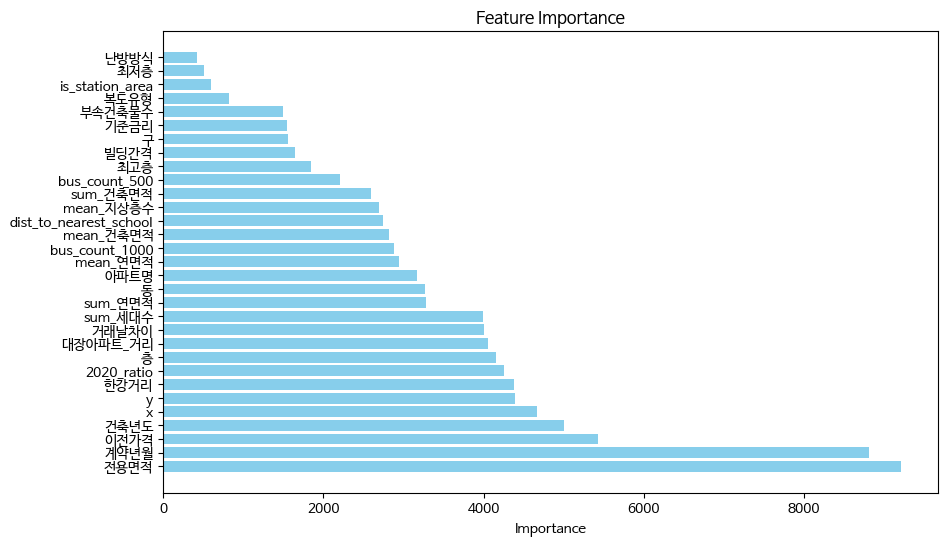

In [90]:
feature_importance = model.feature_importances_

# Get the names of the features
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importance
print(feature_importance_df)

# Optionally, plot the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

In [91]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred_val

# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors


# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting


X_val_sort[['target', 'pred', 'error']].head(50)

,target,pred,error
index,,,
1054669,182000.0,94081.552685,7.729653e+09
800483,189000.0,103141.193928,7.371735e+09
796699,175000.0,99065.436376,5.766058e+09
971177,185000.0,109148.633844,5.753430e+09
956882,167500.0,91992.000638,5.701458e+09
13759,195000.0,121079.579384,5.464229e+09
59846,192000.0,118784.566319,5.360500e+09
3329,199000.0,126705.183444,5.226541e+09
1003249,197000.0,125482.677719,5.114727e+09


In [92]:
X_val_sort[['target', 'pred', 'error']].tail(50)

,target,pred,error
index,,,
612158,135000.0,134959.358369,1651.742193
947979,121000.0,121040.037339,1602.988512
422997,100000.0,100039.958440,1596.676897
920589,145000.0,145039.120877,1530.443046
655144,114500.0,114537.557949,1410.599553
962149,111000.0,110962.470927,1408.431299
121604,92000.0,92036.151268,1306.914190
115748,92500.0,92535.815956,1282.782678
328182,77500.0,77466.831490,1100.150053


In [93]:
# Save the model to a file using pickle
with open('/data/ephemeral/home/upstage-ml-regression-07/house_price_pred/notebooks/SJH/outlier_models/lightgbm_model_class0.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [94]:
pred = model.predict(test0[X_train.columns])
test0['target'] = pred 

## class 1 prediction

In [95]:
X_train = train1[train1['계약년월']<=202212]
y_train = X_train['target']
X_train.drop(columns=['target', 'is_outlier'], inplace=True)


X_val = train1[train1['계약년월']>202212]
y_val = X_val['target']
X_val.drop(columns=['target', 'is_outlier'], inplace=True)

X_train.shape, y_train.shape, X_val.shape, y_val.shape


((8256, 31), (8256,), (1466, 31), (1466,))

In [96]:
# 하이퍼 파라미터 조정하지 않고 모델 성능 체크
model = RandomForestRegressor(n_estimators=100, max_depth=5, criterion='squared_error', random_state=42, n_jobs=-1)
print("\nFitting LightGBM...")
model.fit(X_train, y_train)


Fitting LightGBM...


RandomForestRegressor(max_depth=5, n_jobs=-1, random_state=42)

In [97]:
print("Prediction")
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)


train_score = np.sqrt(evaluation_metric(y_train, pred_train))
val_score = np.sqrt(evaluation_metric(y_val, pred_val))

train_error.append(train_score)
valid_error.append(val_score)

print("Train Score : %.4f" % train_score)
print("Valid Score : %.4f" % val_score)

Prediction
Train Score : 29066.9355
Valid Score : 38812.5489


                   Feature  Importance
24                    이전가격    0.929471
8                     계약년월    0.026266
2                     전용면적    0.018247
11                 sum_연면적    0.005143
29              2020_ratio    0.003388
19  dist_to_nearest_school    0.001628
13                sum_건축면적    0.001607
17                    한강거리    0.001344
30                       구    0.001253
3                        층    0.001122
10                 sum_세대수    0.001118
4                     건축년도    0.001088
12                mean_연면적    0.000949
21          bus_count_1000    0.000920
20           bus_count_500    0.000908
7                     아파트명    0.000882
28                   거래날차이    0.000867
5                        x    0.000822
16                       동    0.000610
6                        y    0.000503
14               mean_건축면적    0.000456
23                대장아파트_거리    0.000326
18                    기준금리    0.000255
9                mean_지상층수    0.000197
27                    빌딩간

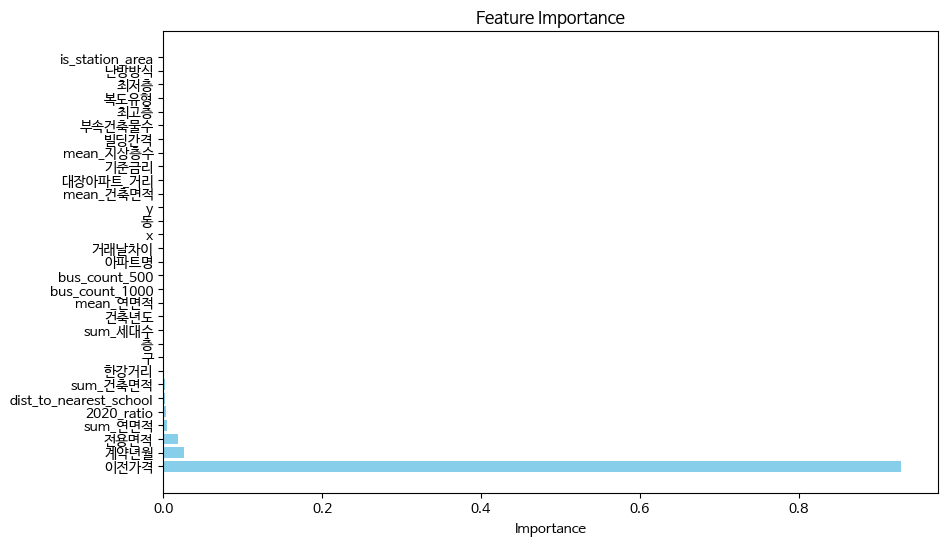

In [98]:
feature_importance = model.feature_importances_

# Get the names of the features
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importance
print(feature_importance_df)

# Optionally, plot the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

In [99]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred_val

# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors


# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting


X_val_sort[['target', 'pred', 'error']].head(50)

,target,pred,error
index,,,
50495,499000.0,264497.438457,5.499145e+10
63033,485000.0,281316.423121,4.148700e+10
6919,485000.0,282621.705373,4.095697e+10
68237,480000.0,280816.548355,3.967405e+10
4286,480000.0,284533.136689,3.820729e+10
23236,493000.0,298264.981206,3.792173e+10
734233,430000.0,242317.271256,3.522481e+10
780812,478000.0,301231.754162,3.124701e+10
50497,465000.0,290196.010730,3.055643e+10


In [100]:
X_val_sort[['target', 'pred', 'error']].tail(50)

,target,pred,error
index,,,
68648,243000.0,244204.325261,1.450399e+06
776154,297000.0,298196.562571,1.431762e+06
1001705,237000.0,235813.718392,1.407264e+06
10230,242500.0,241344.339251,1.335552e+06
727026,233000.0,234135.199584,1.288678e+06
10233,244000.0,245130.100374,1.277127e+06
907154,230000.0,231093.975247,1.196782e+06
757850,350000.0,351047.513346,1.097284e+06
924337,222000.0,223037.628230,1.076672e+06


In [101]:
# Save the model to a file using pickle
with open('/data/ephemeral/home/upstage-ml-regression-07/house_price_pred/notebooks/SJH/outlier_models/randomforest_model_class1.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [102]:
pred = model.predict(test1[X_train.columns])
test1['target'] = pred 

## Class 2 prediction

In [103]:
X_train = train2[train2['계약년월']<=202212]
y_train = X_train['target']
X_train.drop(columns=['target', 'is_outlier'], inplace=True)


X_val = train2[train2['계약년월']>202212]
y_val = X_val['target']
X_val.drop(columns=['target', 'is_outlier'], inplace=True)

X_train.shape, y_train.shape, X_val.shape, y_val.shape


((331, 31), (331,), (61, 31), (61,))

In [104]:
# 하이퍼 파라미터 조정하지 않고 모델 성능 체크
model = RandomForestRegressor(n_estimators=100, max_depth=5, criterion='squared_error', random_state=42, n_jobs=-1)
print("\nFitting LightGBM...")
model.fit(X_train, y_train)


Fitting LightGBM...


RandomForestRegressor(max_depth=5, n_jobs=-1, random_state=42)

In [105]:
print("Prediction")
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)


train_score = np.sqrt(evaluation_metric(y_train, pred_train))
val_score = np.sqrt(evaluation_metric(y_val, pred_val))

train_error.append(train_score)
valid_error.append(val_score)

print("Train Score : %.4f" % train_score)
print("Valid Score : %.4f" % val_score)

Prediction
Train Score : 48497.6339
Valid Score : 91707.5292


                   Feature  Importance
24                    이전가격    0.770430
8                     계약년월    0.038265
19  dist_to_nearest_school    0.029169
28                   거래날차이    0.022465
2                     전용면적    0.022146
25                     최고층    0.016673
4                     건축년도    0.013077
18                    기준금리    0.012058
3                        층    0.011914
23                대장아파트_거리    0.011770
7                     아파트명    0.010755
5                        x    0.005828
9                mean_지상층수    0.004356
10                 sum_세대수    0.004167
27                    빌딩간격    0.003893
14               mean_건축면적    0.003505
13                sum_건축면적    0.003252
6                        y    0.002711
12                mean_연면적    0.001957
21          bus_count_1000    0.001692
16                       동    0.001540
26                     최저층    0.001428
15                  부속건축물수    0.001322
17                    한강거리    0.001209
30                       

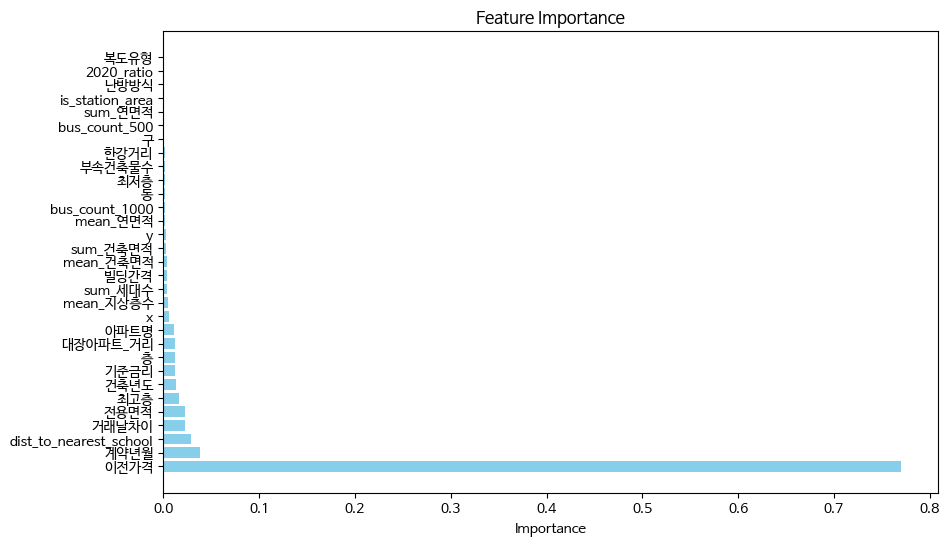

In [106]:
feature_importance = model.feature_importances_

# Get the names of the features
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importance
print(feature_importance_df)

# Optionally, plot the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

In [107]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred_val

# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors


# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting


X_val_sort[['target', 'pred', 'error']].head(50)

,target,pred,error
index,,,
1016272,1100000.0,6.256033e+05,2.250522e+11
63035,821000.0,6.019287e+05,4.799225e+10
49794,780000.0,5.843848e+05,3.826532e+10
734230,545000.0,6.922744e+05,2.168975e+10
765510,500000.0,6.276280e+05,1.628891e+10
776200,555000.0,6.628216e+05,1.162549e+10
724291,500000.0,6.056098e+05,1.115342e+10
1020800,900000.0,1.002182e+06,1.044118e+10
724301,505000.0,6.056098e+05,1.012232e+10


In [108]:
X_val_sort[['target', 'pred', 'error']].tail(50)

,target,pred,error
index,,,
734243,680000.0,597740.468470,6.766631e+09
49795,500000.0,576530.330336,5.856891e+09
33353,500000.0,576451.966357,5.844903e+09
33354,500000.0,570707.425475,4.999540e+09
727014,500000.0,570041.664391,4.905835e+09
727018,725000.0,655085.916062,4.887979e+09
724307,525000.0,594687.509525,4.856349e+09
62795,680000.0,611679.478665,4.667694e+09
48233,510000.0,572181.673243,3.866560e+09


In [109]:
# Save the model to a file using pickle
with open('/data/ephemeral/home/upstage-ml-regression-07/house_price_pred/notebooks/SJH/outlier_models/randomforest_model_class1.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [110]:
pred = model.predict(test2[X_train.columns])
test2['target'] = pred 

In [111]:
print(f"Train RMSE : {sum(train_error)/3}")
print(f"Valid RMSE : {sum(valid_error)/3}")

Train RMSE : 28088.63319235294
Valid RMSE : 47110.63749193365


In [112]:
test.loc[test['is_outlier'] == 0, 'target'] = test0['target']
test.loc[test['is_outlier'] == 1, 'target'] = test1['target']
test.loc[test['is_outlier'] == 2, 'target'] = test2['target']

In [113]:
submission = pd.read_csv("/data/ephemeral/home/sample_submission.csv") 

In [114]:
submission.loc[:, 'target'] = (test.loc[:, 'target']).astype(int)

In [115]:
submission.to_csv("/data/ephemeral/home/upstage-ml-regression-07/house_price_pred/notebooks/SJH/submission/sjh_submission_v14.csv", index=False)

In [116]:
submission['target'].describe()

count    9.272000e+03
mean     9.094603e+04
std      5.186811e+04
min      1.246700e+04
25%      5.810925e+04
50%      8.268000e+04
75%      1.119702e+05
max      1.132657e+06
Name: target, dtype: float64